In [13]:
import matplotlib.pyplot as plt
import os, sys
from typing import Iterable, Dict, List, Callable, Tuple, Union, List

import numpy as np
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

sys.path.append('../')
from dataset import ACDCDataset, MNMDataset
from model.unet import UNet2D
from model.ae import AE
from model.dae import resDAE, AugResDAE
from model.wrapper import Frankenstein, ModelAdapter
from losses import DiceScoreMMS
from utils import  epoch_average

In [3]:
@torch.no_grad()
def test_set(model: nn.Module, dataloader: DataLoader, eval_metrics: Dict) -> Dict:
    model.eval()
    epoch_metrics = {key: [] for key in eval_metrics.keys()}
    # saves batch sizes for each batch for averaging
    batch_sizes = []
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target'].cuda()
        # convert -1 labels to background
        target[target == -1] = 0
        # convert to one-hot encoding
        target = F.one_hot(target.long(), num_classes=4).squeeze(1).permute(0,3,1,2)
        # get model output
        net_out = model(input_.cuda())
        
        batch_sizes.append(input_.shape[0])
        for key, metric in eval_metrics.items():
            epoch_metrics[key].append(metric(net_out, target).detach().mean().cpu())
            
#     for key, epoch_scores in epoch_metrics.items():
#         epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)
        
    return epoch_metrics

In [20]:
### - datasets
debug = False
loader = {}

mnm_a = MNMDataset(vendor='A', debug=debug)
mnm_a_loader = DataLoader(mnm_a, batch_size=1, shuffle=False, drop_last=False)
loader['mnm_siemens'] = mnm_a_loader

loading dataset
loading all case properties


In [21]:
# - instantiate U-Net
unet = UNet2D(n_chans_in=1, n_chans_out=4, n_filters_init=8).cuda()
root = '../../'
unet_path = f'{root}pre-trained-tmp/trained_UNets/acdc_unet8_0_best.pt'
state_dict = torch.load(unet_path)['model_state_dict']
unet.load_state_dict(state_dict)

# - evaluation metrics
eval_metrics = {
        "Volumetric Dice": DiceScoreMMS()
    } 

In [22]:
dsc = test_set(unet, mnm_a_loader, eval_metrics)

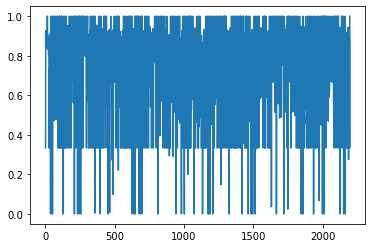

In [23]:
plt.plot(dsc['Volumetric Dice'])

In [30]:
tmp = torch.tensor(dsc['Volumetric Dice'])

In [64]:
indices = (tmp < 0.6667) & (tmp > 0.6665)
indices = indices.nonzero()

In [65]:
subset = mnm_a[indices]

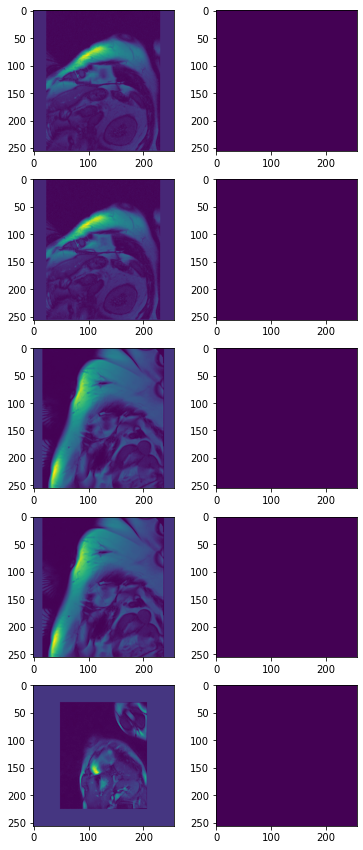

In [66]:
n_samples = 5

img = subset['input'][idx].squeeze()
trg = subset['target'][idx].squeeze()

fig, axes = plt.subplots(n_samples, 2, figsize=(6, n_samples * 3))

for idx in range(n_samples):
    img = subset['input'][idx].squeeze()
    trg = subset['target'][idx].squeeze()
    trg[trg == -1] = 0
    
    
    axes[idx, 0].imshow(img)
    axes[idx, 1].imshow(trg)

In [67]:
trg.sum()

tensor(0.)

In [68]:
t = torch.ones((2,2,2,2))

In [74]:
torch.cumprod(t.size())

TypeError: cumprod() received an invalid combination of arguments - got (torch.Size), but expected one of:
 * (Tensor input, int dim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, name dim, *, torch.dtype dtype, Tensor out)


In [ ]:


# ### - datasets
# debug = False
# loader = {}
# # - ACDC train
# acdc_train = ACDCDataset(data='train', debug=debug)
# acdc_train_loader = DataLoader(acdc_train, batch_size=32, shuffle=False, drop_last=False)
# loader['acdc_train'] = acdc_train_loader
# # - ACDC val
# acdc_val = ACDCDataset(data='val', debug=debug)
# acdc_val_loader = DataLoader(acdc_val, batch_size=32, shuffle=False, drop_last=False)
# loader['acdc_val'] = acdc_val_loader
# # - M&M A
# mnm_a = MNMDataset(vendor='A', debug=debug)
# mnm_a_loader = DataLoader(mnm_a, batch_size=32, shuffle=False, drop_last=False)
# loader['mnm_siemens'] = mnm_a_loader
# # - M&M B
# mnm_b = MNMDataset(vendor='B', debug=debug)
# mnm_b_loader = DataLoader(mnm_b, batch_size=32, shuffle=False, drop_last=False)
# loader['mnm_philips'] = mnm_b_loader
# # - M&M C
# mnm_c = MNMDataset(vendor='C', debug=debug)
# mnm_c_loader = DataLoader(mnm_c, batch_size=32, shuffle=False, drop_last=False)
# loader['mnm_ge'] = mnm_c_loader
# # - M&M D
# mnm_d = MNMDataset(vendor='D', debug=debug)
# mnm_d_loader = DataLoader(mnm_d, batch_size=32, shuffle=False, drop_last=False)
# loader['mnm_canon'] = mnm_d_loader


# # - instantiate U-Net
# unet = UNet2D(n_chans_in=1, n_chans_out=4, n_filters_init=8).cuda()

# #     # - instantiate transformations
# #     layer_ids = ['shortcut0', 'shortcut1', 'shortcut2', 'up3']
# #     #disabled_ids = ['shortcut0', 'shortcut1', 'shortcut2']
# #     disabled_ids = []
# # #                        #    channel, spatial, latent,  depth, block 
# # #     ae_map   = {'up3': [        64,      32,    128,     2,      4]}


# # #     AEs = nn.ModuleDict({'up3': AE(in_channels = ae_map['up3'][0], 
# # #                                         in_dim      = ae_map['up3'][1],
# # #                                         latent_dim  = ae_map['up3'][2],
# # #                                         depth       = ae_map['up3'][3],
# # #                                         block_size  = ae_map['up3'][4])})
# #                        #    channel, spatial, latent,  depth, block 

# #     dae_map   = {
# #          'shortcut0': [         8,     256,    128,     6,      1],
# #          'shortcut1': [        16,     128,    128,     5,      1],
# #          'shortcut2': [        32,      64,    128,     4,      1],
# #          'up3':       [        64,      32,    128,     3,      1]}

# #     DAEs = nn.ModuleDict({key: resDAE(in_channels = dae_map[key][0], 
# #                                       in_dim      = dae_map[key][1],
# #                                       latent_dim  = dae_map[key][2],
# #                                       depth       = dae_map[key][3],
# #                                       block_size  = dae_map[key][4],
# #                                       w_prior     = 1) for key in dae_map})

# #     for layer_id in disabled_ids:
# #          DAEs[layer_id] = nn.Identity()

# #     model = Frankenstein(unet, 
# #                          DAEs, 
# #                          disabled_ids=disabled_ids,
# #                          copy=True)

# ### VAE Params
# layer_ids = ['shortcut0', 'shortcut1', 'shortcut2', 'up3']
# disabled_ids = ['shortcut0', 'shortcut1', 'shortcut2']

#                    #    channel, spatial, latent,  depth, block 
# dae_map   = {
#      #'shortcut0': [         8,     256,    128,     6,      1],
#      #'shortcut1': [        16,     128,    128,     5,      1],
#      #'shortcut2': [        32,      64,    128,     4,      1],
#      'up3':       [        64,      32,    256,     3,      4]}

# #cfg['dae_map'] = dae_map


# DAEs = nn.ModuleDict({key: AugResDAE(in_channels = dae_map[key][0], 
#                                      in_dim      = dae_map[key][1],
#                                      latent_dim  = dae_map[key][2],
#                                      depth       = dae_map[key][3],
#                                      block_size  = dae_map[key][4],
#                                      residual    = True) for key in dae_map})


# for layer_id in disabled_ids:
#      DAEs[layer_id] = nn.Identity()


# model = ModelAdapter(unet, 
#                        DAEs, 
#                        disabled_ids=disabled_ids,
#                        copy=True)


# model.cuda()

# # - evaluation metrics
# eval_metrics = {
#         "Volumetric Dice": DiceScoreMMS()
#     } 
# # - results
# results = {key: [] for key in loader}

# print("Starting evaluation ...")
# # loop over all U-Nets
# for i in range(10):
#     # - path
#     root = '../../'
#     # - load params
#     #ae_path = f'acdc_ae{i}'
#     #model_path = f'{root}pre-trained-tmp/trained_AEs/{ae_path}_best.pt'
#     #model_path = f'{root}pre-trained-tmp/trained_AEs/acdc_resDAE{i}_multi_CEMSE_1prior_best.pt'
#     model_path = f'{root}pre-trained-tmp/trained_AEs/acdc_AugResDAE{i}_localAug_multiImgSingleView_res_balanced_same_best.pt'
#     state_dict = torch.load(model_path)['model_state_dict']
#     model.load_state_dict(state_dict)
#     # hook transformations such that the model output does only contain
#     # the forward pass of the transformed feature maps via the n_samples
#     # key word (i.e. setting it to -1)
#     model.hook_inference_transformations(model.transformations, n_samples=-1)
#     #print(f"Model: {i} - path {ae_path}")
#     # loop over all sets
#     for key in loader:
#         print(f"    Vendor: {key}")
#         dice = test_set(model, loader[key], eval_metrics)
#         results[key].append(dice['Volumetric Dice'].item())

#     np.save('../../results-tmp/heart_downstream_results_localAug_multiImgSingleView_res_balanced_same.npy', results)